# Resource-Constrained Project Scheduling (RCPSP)

This notebook demonstrates how to model a **Resource-Constrained Project Scheduling Problem (RCPSP)**.

## Problem Description

In the RCPSP:
- A **project** consists of a set of **activities** (tasks)
- Activities have **precedence relations** (dependencies)
- Activities consume **renewable resources** during execution
- Each resource has limited **capacity**
- **Objective**: Minimize the project makespan

## Mathematical Model

**Sets**:
- $T$ = set of tasks (activities)
- $R$ = set of renewable resources
- $E$ = set of precedence relations (edges)

**Parameters**:
- $d_t$ = duration of task $t$
- $r_{tr}$ = resource $r$ demand of task $t$
- $C_r$ = capacity of resource $r$

**Variables**:
- $s_t$ = start time of task $t$

**Constraints**:
1. **Precedence**: Task $t$ must finish before task $t'$ starts if $(t, t') \in E$
   $s_{t'} \geq s_t + d_t \quad \forall (t, t') \in E$

2. **Resource capacity**: At any time, resource usage cannot exceed capacity
   $\sum_{t: s_t \leq \tau < s_t + d_t} r_{tr} \leq C_r \quad \forall r \in R, \tau$

**Objective**: 
$\text{minimize} \max_{t \in T} (s_t + d_t)$

In [1]:
# Imports
from pycsp3 import satisfy, minimize, solve, SAT, OPTIMUM, Maximum, clear
from pycsp3_scheduling import (
    IntervalVar, end_before_start, end_time, 
    interval_value, pulse, cumul_range,
    visu
)
from pycsp3_scheduling.variables.interval import clear_interval_registry

print("Imports successful!")

Imports successful!


## Problem Data

In [2]:
# Problem data
durations = [3, 2, 5, 4, 2]
demands = [  # [resource1, resource2] for each task
    [2, 1],
    [1, 2],
    [3, 0],
    [2, 1],
    [1, 3],
]
capacities = [4, 3]
precedences = [(0, 2), (1, 3), (2, 4), (3, 4)]  # (pred, succ) pairs

n_tasks = len(durations)
n_resources = len(capacities)
task_names = [f"T{i}" for i in range(n_tasks)]

print("Problem Instance:")
print(f"  Tasks: {n_tasks}")
print(f"  Resources: {n_resources}")
print()
print("Tasks:")
for i in range(n_tasks):
    demand_str = ", ".join(f"R{r}:{demands[i][r]}" for r in range(n_resources))
    print(f"  {task_names[i]}: duration={durations[i]}, demands=[{demand_str}]")
print()
print("Precedences:")
for pred, succ in precedences:
    print(f"  {task_names[pred]} -> {task_names[succ]}")
print()
print("Resource Capacities:")
for r in range(n_resources):
    print(f"  R{r}: {capacities[r]}")

Problem Instance:
  Tasks: 5
  Resources: 2

Tasks:
  T0: duration=3, demands=[R0:2, R1:1]
  T1: duration=2, demands=[R0:1, R1:2]
  T2: duration=5, demands=[R0:3, R1:0]
  T3: duration=4, demands=[R0:2, R1:1]
  T4: duration=2, demands=[R0:1, R1:3]

Precedences:
  T0 -> T2
  T1 -> T3
  T2 -> T4
  T3 -> T4

Resource Capacities:
  R0: 4
  R1: 3


## Building the Model

In [3]:
# Clear any previous model state
clear()
clear_interval_registry()

# Create interval variables for tasks
tasks = [IntervalVar(size=durations[i], name=task_names[i]) 
         for i in range(n_tasks)]

print("Created task intervals:")
for task in tasks:
    print(f"  {task.name}: duration={task.size_min}")

Created task intervals:
  T0: duration=3
  T1: duration=2
  T2: duration=5
  T3: duration=4
  T4: duration=2


In [4]:
# Precedence constraints
satisfy(
    end_before_start(tasks[pred], tasks[succ]) 
    for pred, succ in precedences
)

print("Precedence constraints added")

Precedence constraints added


In [5]:
# Resource capacity constraints using cumulative functions
for r in range(n_resources):
    resource_usage = sum(
        pulse(tasks[t], demands[t][r])
        for t in range(n_tasks)
        if demands[t][r] > 0
    )
    satisfy(resource_usage <= capacities[r])
    print(f"Resource R{r} capacity constraint: usage <= {capacities[r]}")

Resource R0 capacity constraint: usage <= 4
Resource R1 capacity constraint: usage <= 3


In [6]:
# Minimize makespan
minimize(Maximum(end_time(t) for t in tasks))

print("Objective: Minimize makespan")

Objective: Minimize makespan


## Solving

In [7]:
# Solve
result = solve()

if result in (SAT, OPTIMUM):
    print("Solution found!" + (" (Optimal)" if result == OPTIMUM else ""))
    print()
    print("Task Schedule:")
    for i, task in enumerate(tasks):
        val = interval_value(task)
        demand_str = ", ".join(f"R{r}:{demands[i][r]}" for r in range(n_resources))
        print(f"  {task.name}: [{val.start}, {val.end}] ({demand_str})")
    
    makespan = max(interval_value(t).end for t in tasks)
    print(f"\nMakespan: {makespan}")
else:
    print("No solution found")

Solution found! (Optimal)

Task Schedule:
  T0: [0, 3] (R0:2, R1:1)
  T1: [0, 2] (R0:1, R1:2)
  T2: [6, 11] (R0:3, R1:0)
  T3: [2, 6] (R0:2, R1:1)
  T4: [11, 13] (R0:1, R1:3)

Makespan: 13


## Visualization

We'll show both the task schedule and the resource usage profiles:

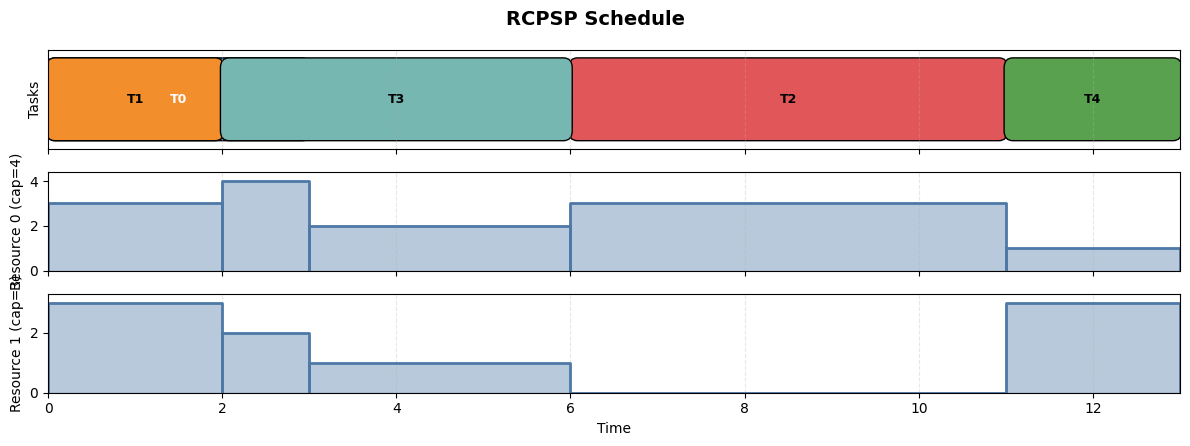

In [8]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(t).end for t in tasks)
    visu.timeline("RCPSP Schedule", origin=0, horizon=makespan)
    
    # Task panel
    visu.panel("Tasks")
    for i, task in enumerate(tasks):
        val = interval_value(task)
        visu.interval(val.start, val.end, task.name, color=i)
    
    # Resource usage panels
    for r in range(n_resources):
        visu.panel(f"Resource {r} (cap={capacities[r]})")
        
        # Compute resource usage at each time point
        # Find all start/end events
        events = []  # (time, delta)
        for i, task in enumerate(tasks):
            if demands[i][r] > 0:
                val = interval_value(task)
                events.append((val.start, demands[i][r]))
                events.append((val.end, -demands[i][r]))
        
        events.sort()
        
        # Build profile segments
        current_usage = 0
        last_time = 0
        for time, delta in events:
            if time > last_time and current_usage > 0:
                visu.segment(last_time, time, current_usage)
            current_usage += delta
            last_time = time
    
    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available)")
        print("\nResource profiles computed successfully")

## Extension: Multi-Mode RCPSP

In Multi-Mode RCPSP, each task can be executed in different **modes**, each with different duration and resource demands:

In [9]:
# Example multi-mode configuration (not applied to model above)
from pycsp3_scheduling import alternative

# Multi-mode data: For each task, list of (duration, [demands]) per mode
modes_example = [
    [(3, [2, 1]), (5, [1, 1])],       # Task 0: 2 modes
    [(2, [1, 2]), (3, [1, 1])],       # Task 1: 2 modes
    [(5, [3, 0]), (4, [2, 1])],       # Task 2: 2 modes
    [(4, [2, 1])],                     # Task 3: 1 mode
    [(2, [1, 3]), (3, [1, 2])],       # Task 4: 2 modes
]

print("Multi-mode example:")
print()
for t, task_modes in enumerate(modes_example):
    print(f"Task {t}:")
    for m, (dur, demands) in enumerate(task_modes):
        print(f"  Mode {m}: duration={dur}, R0={demands[0]}, R1={demands[1]}")

print()
print("To model multi-mode:")
print("  1. Create a main task interval")
print("  2. Create optional mode intervals")
print("  3. Use alternative(main, modes) to select one mode")
print("  4. Apply pulse() to mode intervals for resource constraints")

Multi-mode example:

Task 0:
  Mode 0: duration=3, R0=2, R1=1
  Mode 1: duration=5, R0=1, R1=1
Task 1:
  Mode 0: duration=2, R0=1, R1=2
  Mode 1: duration=3, R0=1, R1=1
Task 2:
  Mode 0: duration=5, R0=3, R1=0
  Mode 1: duration=4, R0=2, R1=1
Task 3:
  Mode 0: duration=4, R0=2, R1=1
Task 4:
  Mode 0: duration=2, R0=1, R1=3
  Mode 1: duration=3, R0=1, R1=2

To model multi-mode:
  1. Create a main task interval
  2. Create optional mode intervals
  3. Use alternative(main, modes) to select one mode
  4. Apply pulse() to mode intervals for resource constraints


## Summary

This notebook demonstrated:

1. **Precedence constraints** with `end_before_start()`
2. **Cumulative resources** with `pulse()` and capacity constraints
3. **Resource visualization** showing usage profiles over time

### Key Functions

| Function | Purpose |
|----------|--------|
| `pulse(task, demand)` | Resource used during task execution |
| `cumul_range(func, min, max)` | Constrain cumulative function |
| `func <= capacity` | Shorthand for `cumul_range(func, 0, capacity)` |
| `visu.segment(start, end, value)` | Draw resource usage segment |